In [24]:
import sys
sys.path.append("..")
import random
from sklearn.model_selection import train_test_split
import numpy as np

import matplotlib.pyplot as plt

from movingpose.estimator import neighbors
from movingpose.estimator import classifiers

from movingpose.preprocessing import moving_pose
from movingpose.preprocessing import kinect_skeleton_data
%matplotlib notebook

## Pickle multiview action data

In [16]:
kinect_skeleton_data.pickle_dir("../pickle/multiview.p", "../ext/dataset/multiview_action/")

Pickling skeleton data...
Saving data...
Saved data to file: ../pickle/multiview.p
Program took 15.321957111358643 to run!


## Load pickled multiview action data

In [4]:
raw_data_dict = kinect_skeleton_data.load_pickle("../pickle/multiview.p")

## Format multiview action data

In [5]:
X, labels = moving_pose.format_skeleton_data_dict(raw_data_dict)

## Visualize formatted skeleton data

<IPython.core.display.Javascript object>


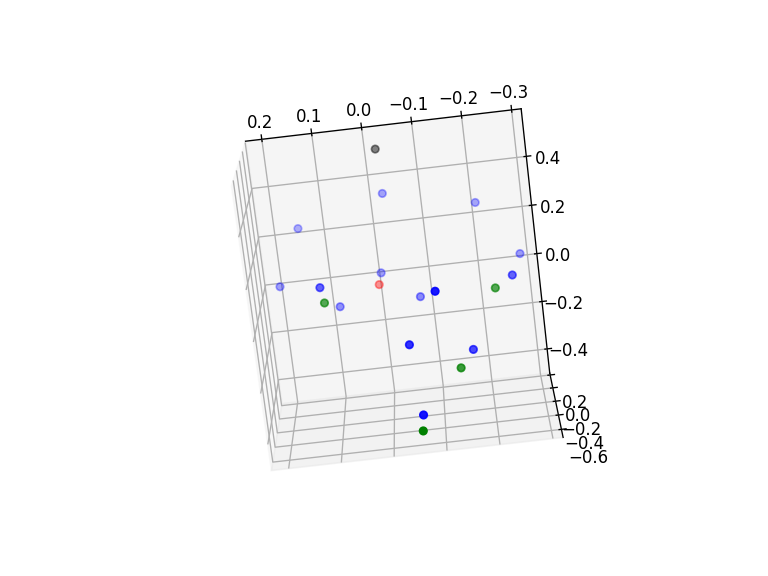

In [38]:
random_action_sequence = random.choice(X)
rand_frame_start_i = random.randint(0, len(random_action_sequence) / 20) * 20
frame_data = random_action_sequence[rand_frame_start_i: rand_frame_start_i + 20]

x = [descriptor[0] for descriptor in frame_data]
y = [descriptor[1] for descriptor in frame_data]
z = [descriptor[2] for descriptor in frame_data]

colors = ['blue' for i in range(20)]
colors[0] = 'red'  # hip is red
colors[7] = 'green'  # hands and feet are green
colors[11] = 'green'
colors[15] = 'green'
colors[19] = 'green'
colors[3] = 'black' # head is black

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z, color=colors, label='Normalized skeleton data')


## Create train/test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, random_state=42)

## Train Action Classifier with normalized training data

In [ ]:
best_score = sys.maxsize
best_action_classifier = None
for n_neighbors in range(5, 15, 5):
    for n_training_neighbors in range(10, 40, 10):
        for alpha in np.arange(0.2, 0.8, 0.1):
            for beta in np.arange(0.1, 0.5, 0.1):
                for kappa in range(3, 10, 1):
                    nearest_descriptor_estimator = neighbors.NearestDescriptors(
                        n_neighbors=n_neighbors,
                        n_training_neighbors=n_training_neighbors,
                        alpha=alpha,
                        beta=beta,
                        kappa=kappa
                    )
                    for theta in np.arange(0.2, 0.8, 0.05):
                        for n in range(5, 15, 1):
                            action_classifier = classifiers.ActionClassifier(
                                nearest_descriptor_estimator=nearest_descriptor_estimator,
                                theta=theta,
                                n=n
                            )
                            action_classifier.fit(X_train, y_train)
                            y_pred = action_classifier.predict(X_test)

                            diff = 0
                            for pred, actual in zip(y_pred, y_test):
                                diff += abs(pred - actual)

                            if diff < best_score:
                                best_score = diff
                                best_action_classifier = action_classifier

## Print best action classifier and its score

In [ ]:
print(f"The best action classifier was {best_action_classifier}")
print("\n--------------\n")
print(f"Its score was: {best_score}")

## Save the best action classifier

In [ ]:
best_action_classifier.save_pickle("../pickle/best_action_classifier.p")

## Load best action classifier

In [ ]:
action_classifier = classifiers.load_pickle("../pickle/best_action_classifier.p")

## Predict live data

In [ ]:
#TODO add live predictions when mehmet publishes the UI code

# DAB

In [ ]:
print("dab")
